In [1]:
from sst1mpipe.io import (
    load_dl1_sst1m,
    load_extra_table,
    load_config
)
from sst1mpipe.performance.sensitivity import (
    get_mc_info,
    get_weights
)

import ctaplot
import json
import matplotlib.pyplot as plt
import numpy as np

from pyirf.spectral import (
    CRAB_HEGRA,
    CRAB_MAGIC_JHEAP2015,
    DAMPE_P_He_SPECTRUM
)
import astropy.units as u
from ctapipe.io import read_table
import matplotlib.colors as colors

In [2]:
config_file = '/mnt/nfs22_auger/jurysek/sst1mpipe/sst1mpipe/data/sst1mpipe_mc_config.json'
config = load_config(config_file)

# Point gammas

In [3]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_point/zenith_20deg/gamma_point_50_300E3GeV_20_20deg_testing_dl1.h5'
telescope = 'tel_001'

gammas_point = load_dl1_sst1m(input_file, tel=telescope, config=config, table='astropy')

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_point/zenith_20deg/gamma_point_50_300E3GeV_20_20deg_testing_dl1.h5
Total N of events of tel_001 : 353113
Applying selection cuts:
camera_frame_hillas_intensity: [0, 1000000]
camera_frame_hillas_width: [0, 100]
camera_frame_hillas_length: [0, 100]
leakage_intensity_width_2: [0, 1]
N of events of tel_001 after selection cuts: 250324
DL1 data loaded as Astropy Table.


In [4]:
# corsika info per job
mc_info = get_mc_info(input_file)

## Histogram of all thrown events

In [5]:
histograms = read_table(input_file, "/simulation/service/shower_distribution")
histograms

obs_id,hist_id,n_entries,bins_energy,bins_core_dist,histogram
,,,TeV,m,
int32,int64,int64,float64[121],float64[201],"float32[120,200]"
100000,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100001,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100002,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100003,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100004,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100005,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100006,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
100007,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0


In [6]:
# historams_merged.shape = (120, 200) = (bins_energy, bins_core_dist)
N_total = histograms['n_entries'].sum()
histograms_merged = np.array(histograms['histogram']).sum(axis=0)
print(N_total)

60000000


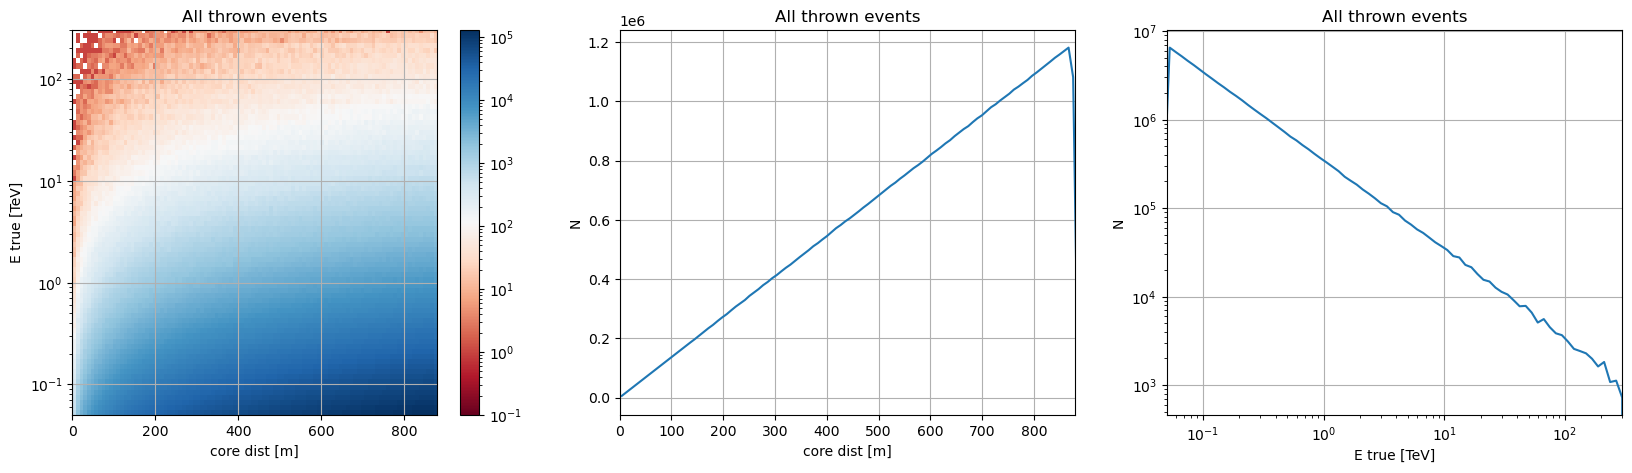

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax1 = fig.add_subplot(ax[0])
ax2 = fig.add_subplot(ax[1])
ax3 = fig.add_subplot(ax[2])

c = ax1.pcolormesh(histograms['bins_core_dist'][0], histograms['bins_energy'][0], histograms_merged, 
                  cmap='RdBu', 
                  norm=colors.LogNorm(vmin=0.1, vmax=histograms_merged.max())
                 )
                  
ax1.set_title('All thrown events')
# set the limits of the plot to the limits of the data
ax1.axis([mc_info.min_impact.value, mc_info.max_impact.value, mc_info.energy_min.value, mc_info.energy_max.value])
fig.colorbar(c, ax=ax1)
ax1.set_xlabel('core dist [m]')
ax1.set_ylabel('E true [TeV]')
ax1.set_yscale('log')
ax1.grid()

ax2.set_title('All thrown events')
core_dist_center = (histograms['bins_core_dist'][0][1:] + histograms['bins_core_dist'][0][:-1]) / 2
ax2.plot(core_dist_center, histograms_merged.sum(axis=0))
ax2.set_xlabel('core dist [m]')
ax2.set_ylabel('N')
ax2.set_xlim([mc_info.min_impact.value, mc_info.max_impact.value])
ax2.grid()

ax3.set_title('All thrown events')
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
ax3.plot(energy_center, histograms_merged.sum(axis=1))
ax3.set_xlabel('E true [TeV]')
ax3.set_ylabel('N')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([mc_info.energy_min.value, mc_info.energy_max.value])
ax3.grid()

In [8]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_point/zenith_20deg/gamma_point_50_300E3GeV_20_20deg_testing_dl1.h5'
telescope = 'tel_001'

# Vladimir checked in raw simtel files that this is indeed a number of all triggered events
gammas_point_no_cuts = load_dl1_sst1m(input_file, tel=telescope, table='astropy')

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_point/zenith_20deg/gamma_point_50_300E3GeV_20_20deg_testing_dl1.h5
Total N of events of tel_001 : 353113
N of events of tel_001 after selection cuts: 353113
DL1 data loaded as Astropy Table.


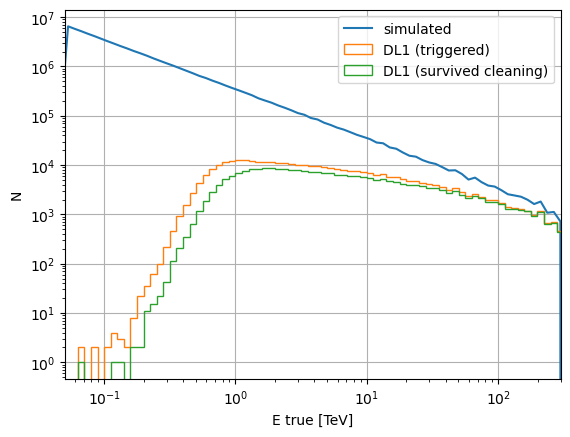

In [9]:
plt.figure()
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
plt.plot(energy_center, histograms_merged.sum(axis=1), label='simulated')

plt.hist(gammas_point_no_cuts['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (triggered)')
plt.hist(gammas_point['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (survived cleaning)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([mc_info.energy_min.value, mc_info.energy_max.value])
plt.xlabel('E true [TeV]')
plt.ylabel('N')
plt.grid()
plt.legend()

In [10]:
# Re-weighting on the real spectrum (Crab MAGIC)
simulated_event_info = get_mc_info(input_file)
OBS_TIME = 50*u.hour
gammas_point = get_weights(gammas_point, mc_info=simulated_event_info, obs_time=OBS_TIME, target_spectrum=CRAB_MAGIC_JHEAP2015)
gammas_point_no_cuts = get_weights(gammas_point_no_cuts, mc_info=simulated_event_info, obs_time=OBS_TIME, target_spectrum=CRAB_MAGIC_JHEAP2015)

Total number of events observed in OBS_TIME: 5407.449224567081
Event rate: 0.030041384580928226 1 / s


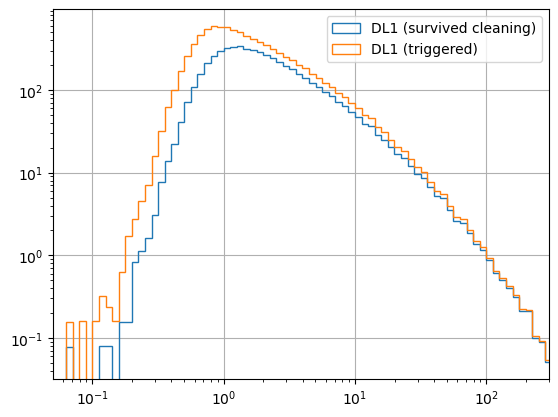

In [11]:
plt.figure()
plt.hist(gammas_point['true_energy'], weights=gammas_point["weight"], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (survived cleaning)')
plt.hist(gammas_point_no_cuts['true_energy'], weights=gammas_point_no_cuts["weight"], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (triggered)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([mc_info.energy_min.value, mc_info.energy_max.value])
plt.grid()
plt.legend()

N_observed = sum(gammas_point["weight"])

print('Total number of events observed in OBS_TIME:', N_observed)
print('Event rate:', N_observed/ OBS_TIME.to(u.s))

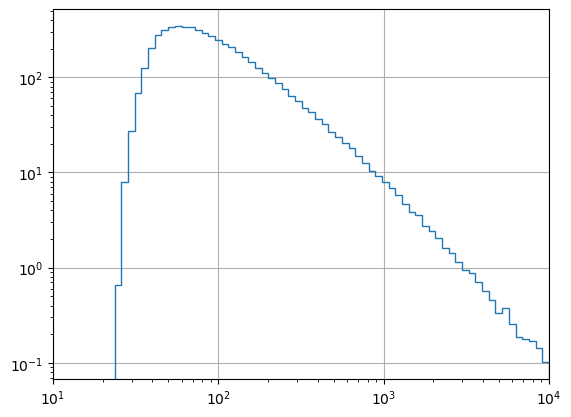

In [12]:
intensity_bins = np.logspace(0, 4, 100)
plt.figure()
plt.hist(gammas_point['camera_frame_hillas_intensity'], weights=gammas_point["weight"], bins=intensity_bins, histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 10000])
plt.grid()


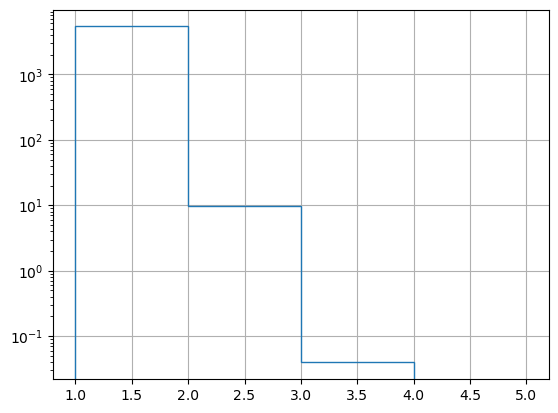

In [13]:
plt.figure()
plt.hist(gammas_point['morphology_n_islands'], weights=gammas_point["weight"], bins=4, range=[1, 5],histtype='step')
plt.yscale('log')
plt.grid()

# Diffuse gammas

In [33]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_diffuse/zenith_20deg/gamma_50_300E3GeV_20_20deg_testing_dl1.h5'
telescope = 'tel_001'
gammas_diffuse = load_dl1_sst1m(input_file, tel=telescope, config=config, table='astropy')

# Histograms of thrown events
histograms = read_table(input_file, "/simulation/service/shower_distribution")
histograms

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_diffuse/zenith_20deg/gamma_50_300E3GeV_20_20deg_testing_dl1.h5
Total N of events of tel_001 : 46478
Applying selection cuts:
camera_frame_hillas_intensity: [0, 1000000]
camera_frame_hillas_width: [0, 100]
camera_frame_hillas_length: [0, 100]
leakage_intensity_width_2: [0, 1]
N of events of tel_001 after selection cuts: 32570
DL1 data loaded as Astropy Table.


obs_id,hist_id,n_entries,bins_energy,bins_core_dist,histogram
,,,TeV,m,
int32,int64,int64,float64[121],float64[201],"float32[120,200]"
200005,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200006,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200007,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200008,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200009,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200015,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200016,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0
200017,6,20000,0.001 .. 1000.0,0.0 .. 1760.0,0.0 .. 0.0


In [34]:
# historams_merged.shape = (120, 200) = (bins_energy, bins_core_dist)
N_total = histograms['n_entries'].sum()
histograms_merged = np.array(histograms['histogram']).sum(axis=0)
print(N_total)

50000000


In [35]:
# corsika info per job
mc_info = get_mc_info(input_file)

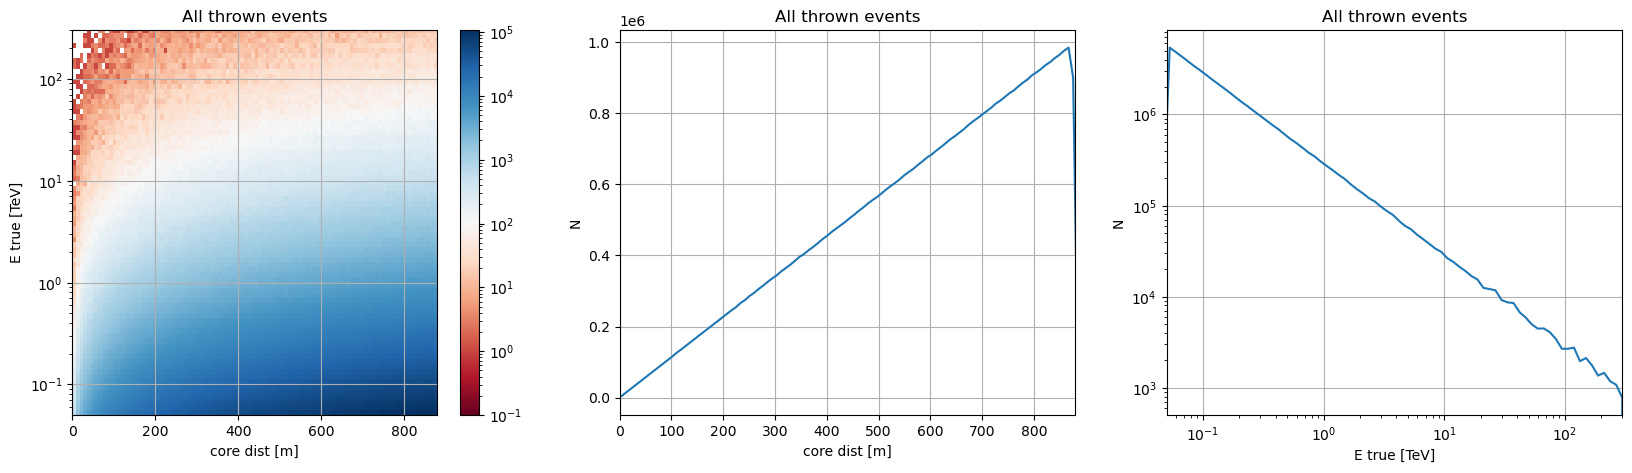

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax1 = fig.add_subplot(ax[0])
ax2 = fig.add_subplot(ax[1])
ax3 = fig.add_subplot(ax[2])

c = ax1.pcolormesh(histograms['bins_core_dist'][0], histograms['bins_energy'][0], histograms_merged, 
                  cmap='RdBu', 
                  norm=colors.LogNorm(vmin=0.1, vmax=histograms_merged.max())
                 )
                  
ax1.set_title('All thrown events')
# set the limits of the plot to the limits of the data
ax1.axis([mc_info.min_impact.value, mc_info.max_impact.value, mc_info.energy_min.value, mc_info.energy_max.value])
fig.colorbar(c, ax=ax1)
ax1.set_xlabel('core dist [m]')
ax1.set_ylabel('E true [TeV]')
ax1.set_yscale('log')
ax1.grid()

ax2.set_title('All thrown events')
core_dist_center = (histograms['bins_core_dist'][0][1:] + histograms['bins_core_dist'][0][:-1]) / 2
ax2.plot(core_dist_center, histograms_merged.sum(axis=0))
ax2.set_xlabel('core dist [m]')
ax2.set_ylabel('N')
ax2.set_xlim([mc_info.min_impact.value, mc_info.max_impact.value])
ax2.grid()

ax3.set_title('All thrown events')
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
ax3.plot(energy_center, histograms_merged.sum(axis=1))
ax3.set_xlabel('E true [TeV]')
ax3.set_ylabel('N')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([mc_info.energy_min.value, mc_info.energy_max.value])
ax3.grid()

In [37]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_diffuse/zenith_20deg/gamma_50_300E3GeV_20_20deg_testing_dl1.h5'
gammas_diffuse_no_cuts = load_dl1_sst1m(input_file, tel=telescope, table='astropy')

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/gammas_diffuse/zenith_20deg/gamma_50_300E3GeV_20_20deg_testing_dl1.h5
Total N of events of tel_001 : 46478
N of events of tel_001 after selection cuts: 46478
DL1 data loaded as Astropy Table.


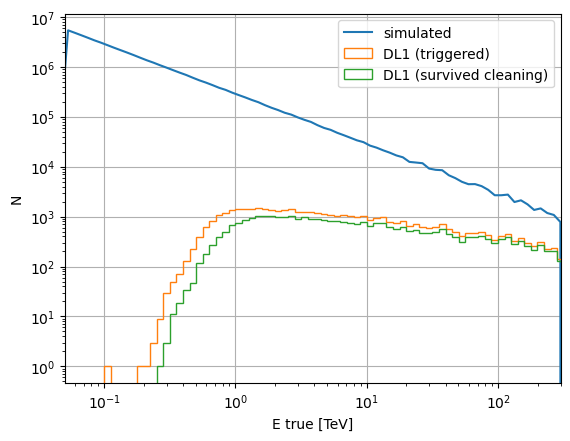

In [38]:
plt.figure()
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
plt.plot(energy_center, histograms_merged.sum(axis=1), label='simulated')
plt.hist(gammas_diffuse_no_cuts['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (triggered)')
plt.hist(gammas_diffuse['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (survived cleaning)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([mc_info.energy_min.value, mc_info.energy_max.value])
plt.xlabel('E true [TeV]')
plt.ylabel('N')
plt.grid()
plt.legend()

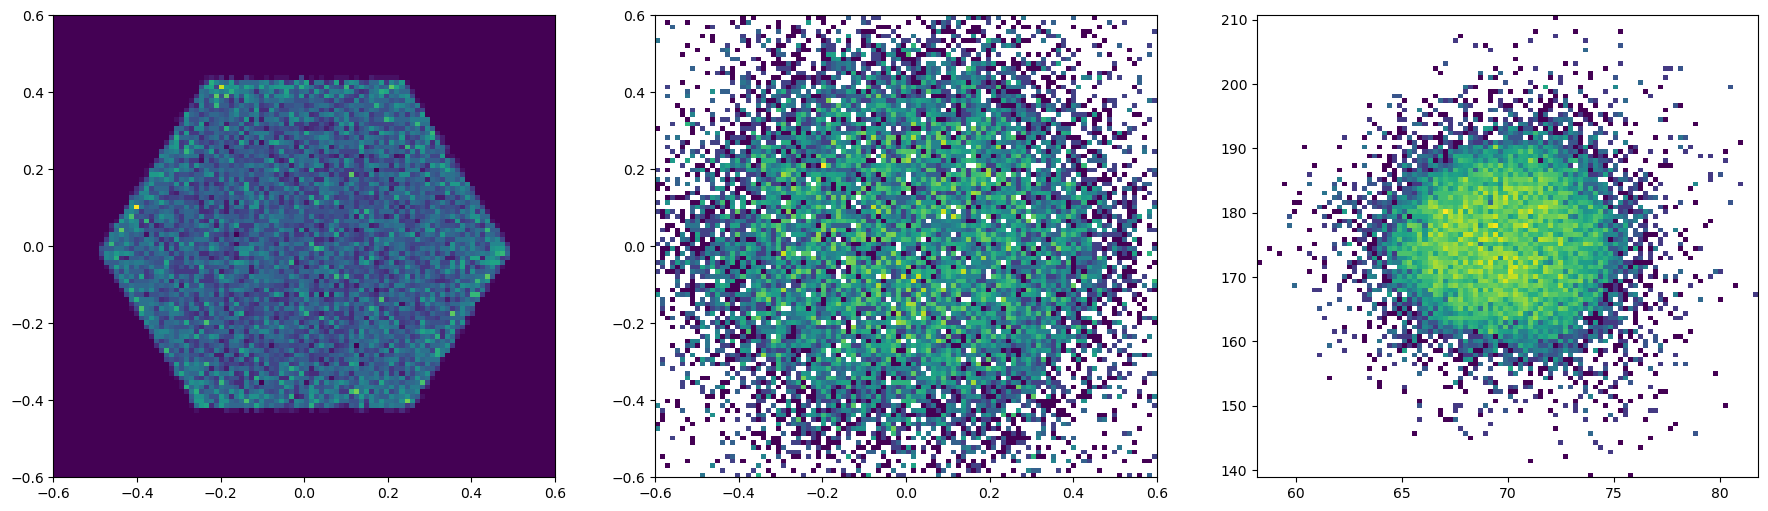

In [39]:
import matplotlib as mpl
fig, ax = plt.subplots(1, 3, figsize=(22, 6))

ax1 = fig.add_subplot(ax[0])
ax2 = fig.add_subplot(ax[1])
ax3 = fig.add_subplot(ax[2])

h = ax1.hist2d(gammas_diffuse['camera_frame_hillas_x'], gammas_diffuse['camera_frame_hillas_y'], bins=100, range=np.array([(-0.6, 0.6), (-0.6, 0.6)]))
h = ax2.hist2d(gammas_diffuse['true_camera_x'], gammas_diffuse['true_camera_y'], bins=100, norm=mpl.colors.LogNorm(), range=np.array([(-0.6, 0.6), (-0.6, 0.6)]))
h = ax3.hist2d(gammas_diffuse['true_alt'], gammas_diffuse['true_az'], bins=100, norm=mpl.colors.LogNorm()) #, range=np.array([(-0.6, 0.6), (-0.6, 0.6)]))



# Diffuse protons

In [20]:
input_file = '/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/protons_diffuse/zenith_20deg/proton_100_500E3GeV_20_20deg_training_dl1.h5'
telescope = 'tel_001'

proton_diffuse = load_dl1_sst1m(input_file, tel=telescope, config=config)

histograms = read_table(input_file, "/simulation/service/shower_distribution")
histograms

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/protons_diffuse/zenith_20deg/proton_100_500E3GeV_20_20deg_training_dl1.h5
Total N of events of tel_001 : 159327
Applying selection cuts:
camera_frame_hillas_intensity: [0, 1000000]
camera_frame_hillas_width: [0, 100]
camera_frame_hillas_length: [0, 100]
leakage_intensity_width_2: [0, 1]
N of events of tel_001 after selection cuts: 104941
DL1 data loaded as Astropy Table.


obs_id,hist_id,n_entries,bins_energy,bins_core_dist,histogram
,,,TeV,m,
int32,int64,int64,float64[121],float64[201],"float32[120,200]"
300000,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300001,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300002,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300003,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300004,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300010,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300011,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0
300012,6,40000,0.001 .. 1000.0,0.0 .. 2000.0,0.0 .. 0.0


In [21]:
# historams_merged.shape = (120, 200) = (bins_energy, bins_core_dist)
N_total = histograms['n_entries'].sum()
histograms_merged = np.array(histograms['histogram']).sum(axis=0)
print(N_total)

260000000


In [22]:
# corsika info per job
mc_info = get_mc_info(input_file)

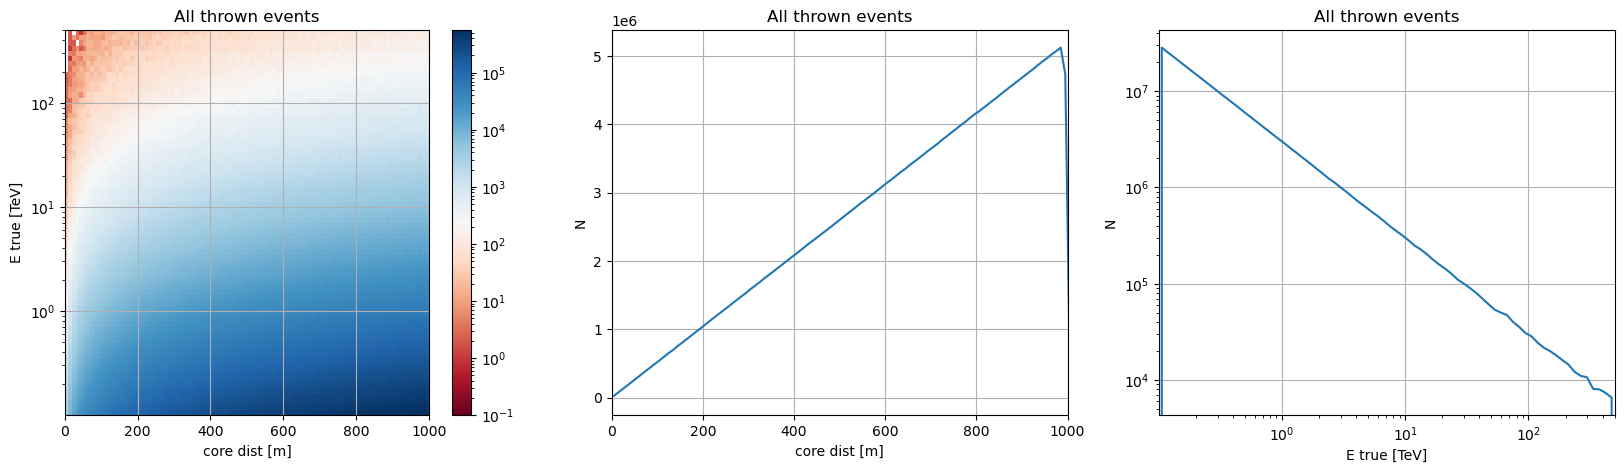

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax1 = fig.add_subplot(ax[0])
ax2 = fig.add_subplot(ax[1])
ax3 = fig.add_subplot(ax[2])

c = ax1.pcolormesh(histograms['bins_core_dist'][0], histograms['bins_energy'][0], histograms_merged, 
                  cmap='RdBu', 
                  norm=colors.LogNorm(vmin=0.1, vmax=histograms_merged.max())
                 )
                  
ax1.set_title('All thrown events')
# set the limits of the plot to the limits of the data
ax1.axis([mc_info.min_impact.value, mc_info.max_impact.value, mc_info.energy_min.value, mc_info.energy_max.value])
fig.colorbar(c, ax=ax1)
ax1.set_xlabel('core dist [m]')
ax1.set_ylabel('E true [TeV]')
ax1.set_yscale('log')
ax1.grid()

ax2.set_title('All thrown events')
core_dist_center = (histograms['bins_core_dist'][0][1:] + histograms['bins_core_dist'][0][:-1]) / 2
ax2.plot(core_dist_center, histograms_merged.sum(axis=0))
ax2.set_xlabel('core dist [m]')
ax2.set_ylabel('N')
ax2.set_xlim([mc_info.min_impact.value, mc_info.max_impact.value])
ax2.grid()

ax3.set_title('All thrown events')
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
ax3.plot(energy_center, histograms_merged.sum(axis=1))
ax3.set_xlabel('E true [TeV]')
ax3.set_ylabel('N')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([mc_info.energy_min.value, mc_info.energy_max.value])
ax3.grid()

In [24]:
proton_diffuse_no_cuts = load_dl1_sst1m(input_file, tel=telescope)

/mnt/nfs22_auger/jurysek/SST1M/MC/prod_january_2023/DL1/protons_diffuse/zenith_20deg/proton_100_500E3GeV_20_20deg_training_dl1.h5
Total N of events of tel_001 : 159327
N of events of tel_001 after selection cuts: 159327
DL1 data loaded as Astropy Table.


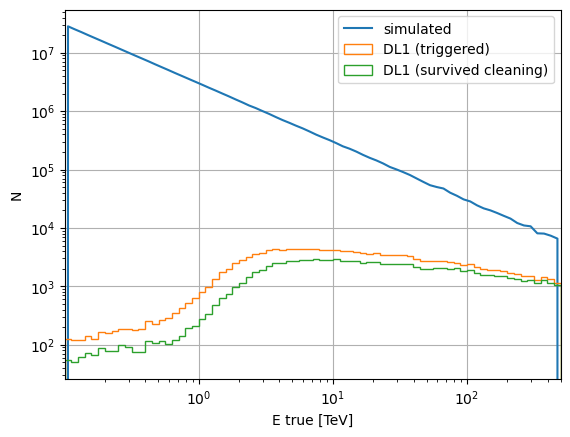

In [25]:
plt.figure()
energy_center = ctaplot.ana.logbin_mean(histograms['bins_energy'][0])
plt.plot(energy_center, histograms_merged.sum(axis=1), label='simulated')

plt.hist(proton_diffuse_no_cuts['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (triggered)')
plt.hist(proton_diffuse['true_energy'], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (survived cleaning)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([mc_info.energy_min.value, mc_info.energy_max.value])
plt.xlabel('E true [TeV]')
plt.ylabel('N')
plt.grid()
plt.legend()

In [26]:
# Re-weighting on the real spectrum (DAMPE p+He)
simulated_event_info = get_mc_info(input_file)

In [27]:
OBS_TIME = 50*u.hour
proton_diffuse = get_weights(proton_diffuse, mc_info=simulated_event_info, obs_time=OBS_TIME, target_spectrum=DAMPE_P_He_SPECTRUM)
proton_diffuse_no_cuts = get_weights(proton_diffuse_no_cuts, mc_info=simulated_event_info, obs_time=OBS_TIME, target_spectrum=DAMPE_P_He_SPECTRUM)

Total number of events observed in OBS_TIME: 12917175.723689415
Event rate: 71.76208735383008 1 / s


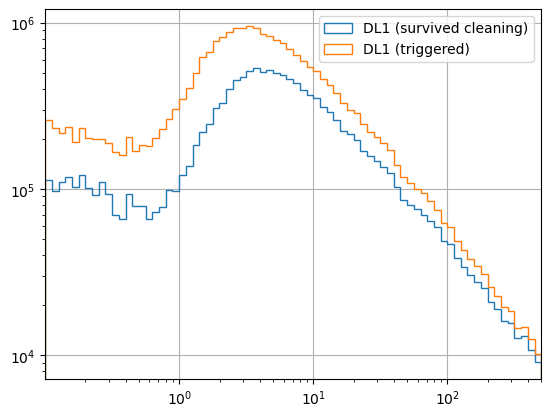

In [28]:
plt.figure()
plt.hist(proton_diffuse['true_energy'], weights=proton_diffuse["weight"], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (survived cleaning)')
plt.hist(proton_diffuse_no_cuts['true_energy'], weights=proton_diffuse_no_cuts["weight"], bins=histograms['bins_energy'][0], histtype='step', label='DL1 (triggered)')
plt.xscale('log')
plt.yscale('log')
plt.xlim([mc_info.energy_min.value, mc_info.energy_max.value])
plt.grid()
plt.legend()

N_observed = sum(proton_diffuse["weight"])

print('Total number of events observed in OBS_TIME:', N_observed)
print('Event rate:', N_observed/ OBS_TIME.to(u.s))

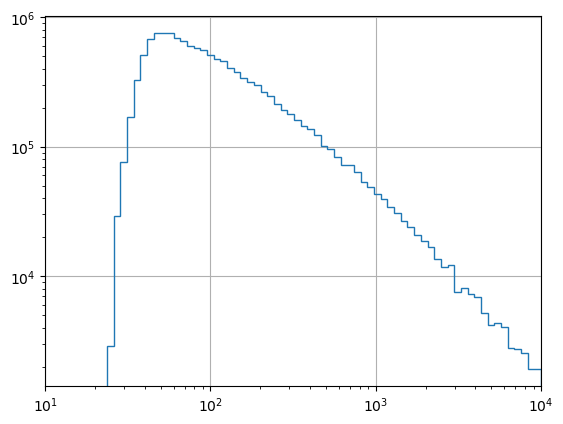

In [29]:
intensity_bins = np.logspace(0, 4, 100)
plt.figure()
plt.hist(proton_diffuse['camera_frame_hillas_intensity'], weights=proton_diffuse["weight"], bins=intensity_bins, histtype='step')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 10000])
plt.grid()

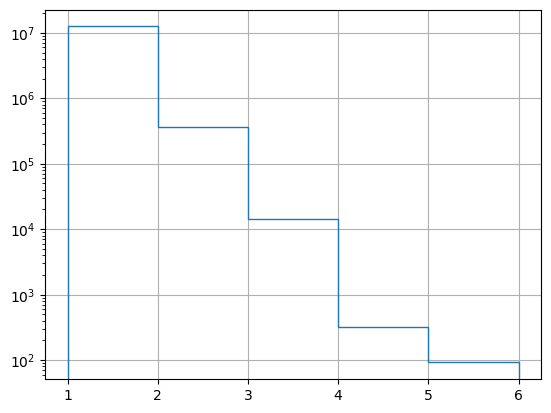

In [30]:
plt.figure()
plt.hist(proton_diffuse['morphology_n_islands'], weights=proton_diffuse["weight"], bins=5, range=[1, 6],histtype='step')
plt.yscale('log')
plt.grid()